# 내일은 얼마조 ?
원유, 환율, 다우지수, S&P500을 이용한 국내 항공업 주가 예측하기

#1.필요한 데이터 가져오기 : finance-datareader 

- investing.com에서 주식 정보를 가져오는 파이썬 오픈 소스 라이브러리

- 유의사항 : 이런 오픈 소스 라이브러리들은 해외 주식 사이트에서 API 등 사용해 데이터를 가져옵니다. 해당 사이트의 API 지원이 중단되거나, 라이브러리 자체에 변경사항이 있으면, 데이터를 가져오는 기능이 잠시 원활하지 않을 수도 있습니다. 그래서 테스트 용도로 주식 가격을 활용하고자 할 때 추천드립니다.



In [1]:
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import FinanceDataReader as fdr

### 원유

원유 가격의 경우, 
* Finance Data Reader의 데이터가 *investing.com*의 데이터와 불일치
* **-->** *investing.com*의 데이터를 직접 다운받아 불러오는 방식으로 처리

원유 가중치 계산:

0.8 * dubai + 0.15 * brent + 0.05 * wti

(참고 논문에 따라, 수입 의존도에 따른 가중을 두어 기준유가를 계산해 사용함)



In [3]:
from google.colab import files
myFile = files.upload()

Saving WTI유 선물 내역.csv to WTI유 선물 내역.csv
Saving 브렌트유 선물 내역.csv to 브렌트유 선물 내역.csv
Saving 두바이유 내역.csv to 두바이유 내역.csv


In [4]:
import pandas as pd
wti = pd.read_csv('WTI유 선물 내역.csv')
wti

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2022- 11- 04,92.61,87.90,92.87,87.82,NaN,5.04%
1,2022- 11- 03,88.17,89.35,89.67,87.60,239.82K,-2.03%
2,2022- 11- 02,90.00,88.62,90.36,87.72,280.96K,1.84%
3,2022- 11- 01,88.37,86.43,89.45,85.92,274.32K,2.13%
4,2022- 10- 31,86.53,88.39,88.65,85.30,285.34K,-1.56%
...,...,...,...,...,...,...,...
2193,2014- 07- 14,87.94,87.94,87.94,87.94,151.22K,0.76%
2194,2014- 07- 11,87.28,87.28,87.28,87.28,122.75K,-0.46%
2195,2014- 07- 10,87.68,87.68,87.68,87.68,124.03K,-0.62%
2196,2014- 07- 09,88.23,88.23,88.23,88.23,121.59K,-0.15%


In [5]:
dubai = pd.read_csv('두바이유 내역.csv')
dubai

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2022- 11- 04,93.63,93.63,93.63,93.63,NaN,4.62%
1,2022- 11- 03,89.50,89.50,89.50,89.50,NaN,-2.58%
2,2022- 11- 02,91.87,91.87,91.87,91.87,NaN,0.71%
3,2022- 11- 01,91.22,91.22,91.22,91.22,NaN,0.10%
4,2022- 10- 31,91.13,91.13,91.13,91.13,NaN,0.02%
...,...,...,...,...,...,...,...
2093,2014- 07- 14,106.19,106.19,106.19,106.19,NaN,0.38%
2094,2014- 07- 11,105.79,105.79,105.79,105.79,NaN,-1.00%
2095,2014- 07- 10,106.86,106.86,106.86,106.86,NaN,0.27%
2096,2014- 07- 09,106.57,106.57,106.57,106.57,NaN,1.30%


In [6]:
brent = pd.read_csv('브렌트유 선물 내역.csv')
brent

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2022- 11- 04,98.57,94.58,98.81,94.33,307.09K,4.12%
1,2022- 11- 03,94.67,95.36,95.98,94.19,229.12K,-1.55%
2,2022- 11- 02,96.16,94.85,96.50,94.01,253.00K,1.60%
3,2022- 11- 01,94.65,92.67,95.55,92.33,247.65K,-0.19%
4,2022- 10- 31,94.83,96.47,96.47,94.25,15.00K,-0.98%
...,...,...,...,...,...,...,...
2148,2014- 07- 14,106.98,106.42,107.50,106.21,99.20K,0.30%
2149,2014- 07- 11,106.66,108.58,108.74,106.27,171.04K,-1.85%
2150,2014- 07- 10,108.67,108.15,108.88,107.76,152.47K,0.36%
2151,2014- 07- 09,108.28,108.97,109.00,108.12,173.18K,-0.61%


In [7]:
# 날짜 재정렬: 오래된 날짜부터 최신 날짜까지의 순서로 다시 정렬

oil_list = [wti, dubai, brent]
oil_list_names = ['WTI', 'Dubai', 'Brent']

for i in oil_list:
  i = i[::-1]
  i.reset_index(drop=True, inplace=True)
  print(i)

                날짜     종가     오픈     고가     저가      거래량    변동 %
0     2014- 07- 08  88.36  88.36  88.36  88.36  119.19K  -0.43%
1     2014- 07- 09  88.23  88.23  88.23  88.23  121.59K  -0.15%
2     2014- 07- 10  87.68  87.68  87.68  87.68  124.03K  -0.62%
3     2014- 07- 11  87.28  87.28  87.28  87.28  122.75K  -0.46%
4     2014- 07- 14  87.94  87.94  87.94  87.94  151.22K   0.76%
...            ...    ...    ...    ...    ...      ...     ...
2193  2022- 10- 31  86.53  88.39  88.65  85.30  285.34K  -1.56%
2194  2022- 11- 01  88.37  86.43  89.45  85.92  274.32K   2.13%
2195  2022- 11- 02  90.00  88.62  90.36  87.72  280.96K   1.84%
2196  2022- 11- 03  88.17  89.35  89.67  87.60  239.82K  -2.03%
2197  2022- 11- 04  92.61  87.90  92.87  87.82      NaN   5.04%

[2198 rows x 7 columns]
                날짜      종가      오픈      고가      저가  거래량    변동 %
0     2014- 07- 08  105.20  105.20  105.20  105.20  NaN   0.00%
1     2014- 07- 09  106.57  106.57  106.57  106.57  NaN   1.30%
2     2014- 07-

In [8]:
# 불필요한 칼럼 삭제

for i in oil_list:
  i.drop(['오픈','고가','저가','거래량','변동 %'], axis=1, inplace=True)

In [9]:
# 날짜 데이터 타입 통일을 위해 datetime 타입으로 변경

for i in oil_list:
  i['날짜'] = pd.to_datetime(i['날짜'])

In [10]:
#변경된 것 확인
wti['날짜']

0      2022-11-04
1      2022-11-03
2      2022-11-02
3      2022-11-01
4      2022-10-31
          ...    
2193   2014-07-14
2194   2014-07-11
2195   2014-07-10
2196   2014-07-09
2197   2014-07-08
Name: 날짜, Length: 2198, dtype: datetime64[ns]

In [11]:
# 변수 데이터들 간 형식 통일을 위해
# Date를 인덱스로, Close를 열로 변경

for i in oil_list:
  i.columns = ['Date','Close']
  i.set_index('Date',inplace=True)

In [12]:
wti

,Close
Date,
2022-11-04,92.61
2022-11-03,88.17
2022-11-02,90.00
2022-11-01,88.37
2022-10-31,86.53
...,...
2014-07-14,87.94
2014-07-11,87.28
2014-07-10,87.68


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss

In [14]:
#정상성검정 함수
def adf_test(timeseries, pvalue = .20, regression_option = 'ct'):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] < pvalue:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.")
    else:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.")

In [15]:
adf_test(wti)
adf_test(dubai)
adf_test(brent)

Results of Dickey-Fuller Test:
Test Statistic                   -1.172704
p-value                           0.915948
Lags Used                        22.000000
Number of Observations Used    2175.000000
Critical Value (1%)              -3.962938
Critical Value (5%)              -3.412510
Critical Value (10%)             -3.128240
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.
Results of Dickey-Fuller Test:
Test Statistic                   -0.331672
p-value                           0.988757
Lags Used                         0.000000
Number of Observations Used    2097.000000
Critical Value (1%)              -3.963094
Critical Value (5%)              -3.412586
Critical Value (10%)             -3.128284
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.
Results of Dickey-Fuller Test:
Test Statistic                   -1.075708
p-value                           0.933026
Lags Used                        18.000000
Number of Ob

In [16]:
def kpss_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression= regression_option)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < pvalue:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.")
    else:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.")

In [17]:
kpss_test(wti)
kpss_test(brent)
kpss_test(dubai)

Results of KPSS Test:
Test Statistic            1.277942
p-value                   0.010000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.
Results of KPSS Test:
Test Statistic            0.625217
p-value                   0.010000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.
Results of KPSS Test:
Test Statistic            0.596475
p-value                   0.010000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value re

In [18]:
#Close 에 있는 데이터들을 t-1기로 한칸씩 미룸
wti_sta = wti["Close"].to_frame(name="Close") # 데이터의 행을 역순으로 뒤집는 부분 
wti_sta["lag_1"] = wti_sta["Close"].shift(periods=1)

wti_sta

,Close,lag_1
Date,,
2022-11-04,92.61,NaN
2022-11-03,88.17,92.61
2022-11-02,90.00,88.17
2022-11-01,88.37,90.00
2022-10-31,86.53,88.37
...,...,...
2014-07-14,87.94,87.35
2014-07-11,87.28,87.94
2014-07-10,87.68,87.28


In [19]:
# t - (t-1)를 통해 차분
wti_sta['Close2'] = wti_sta['Close'] - wti_sta['lag_1'] 
wti_sta['Close3'] = wti_sta['Close'].diff(1)

wti_sta

,Close,lag_1,Close2,Close3
Date,,,,
2022-11-04,92.61,NaN,NaN,NaN
2022-11-03,88.17,92.61,-4.44,-4.44
2022-11-02,90.00,88.17,1.83,1.83
2022-11-01,88.37,90.00,-1.63,-1.63
2022-10-31,86.53,88.37,-1.84,-1.84
...,...,...,...,...
2014-07-14,87.94,87.35,0.59,0.59
2014-07-11,87.28,87.94,-0.66,-0.66
2014-07-10,87.68,87.28,0.40,0.40


Results of Dickey-Fuller Test:
Test Statistic                -9.258796e+00
p-value                        9.514707e-14
Lags Used                      2.600000e+01
Number of Observations Used    2.170000e+03
Critical Value (1%)           -3.962948e+00
Critical Value (5%)           -3.412515e+00
Critical Value (10%)          -3.128242e+00
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.032704
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


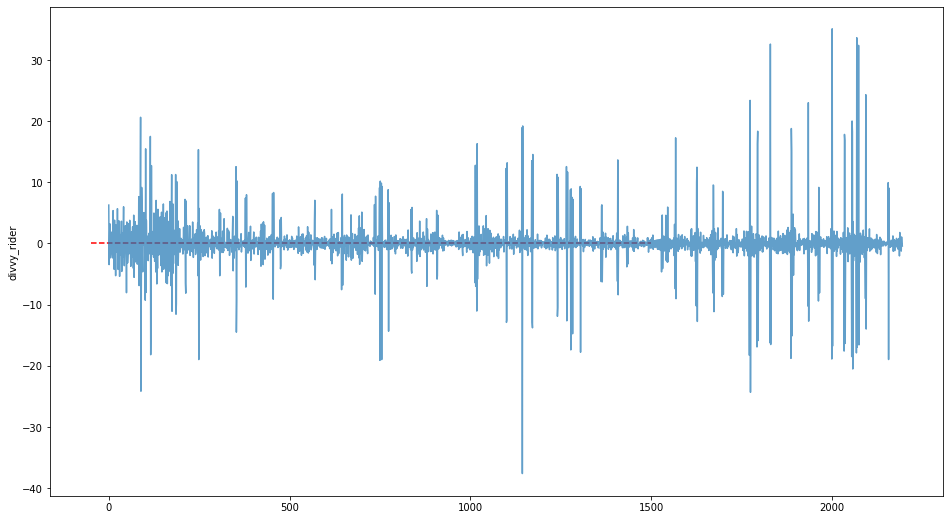

In [20]:
#Close 에 있는 데이터들을 t-1기로 한칸씩 미룸
wti_sta = wti["Close"].to_frame(name="Close") # 데이터의 행을 역순으로 뒤집는 부분 
wti_sta["lag_1"] = wti_sta["Close"].shift(periods=1)

# t - (t-1)를 통해 차분
wti_sta['Close2'] = wti_sta['Close'] - wti_sta['lag_1'] 
wti_sta['Close3'] = wti_sta['Close'].diff(1)

#결측치 드랍
wti_sta.dropna(inplace=True)
wti_sta

#검증
adf_test(wti_sta['Close2'])
kpss_test(wti_sta['Close2'])

diff_wti = wti_sta['Close2'].diff(1).dropna()

# 표 그리기
plt.figure(figsize=(16,9))
plt.plot(diff_wti.values, alpha=.7)
plt.hlines(y=diff_wti.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed')
plt.ylabel('divvy_rider')
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.258796e+00
p-value                        9.514707e-14
Lags Used                      2.600000e+01
Number of Observations Used    2.170000e+03
Critical Value (1%)           -3.962948e+00
Critical Value (5%)           -3.412515e+00
Critical Value (10%)          -3.128242e+00
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.032704
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


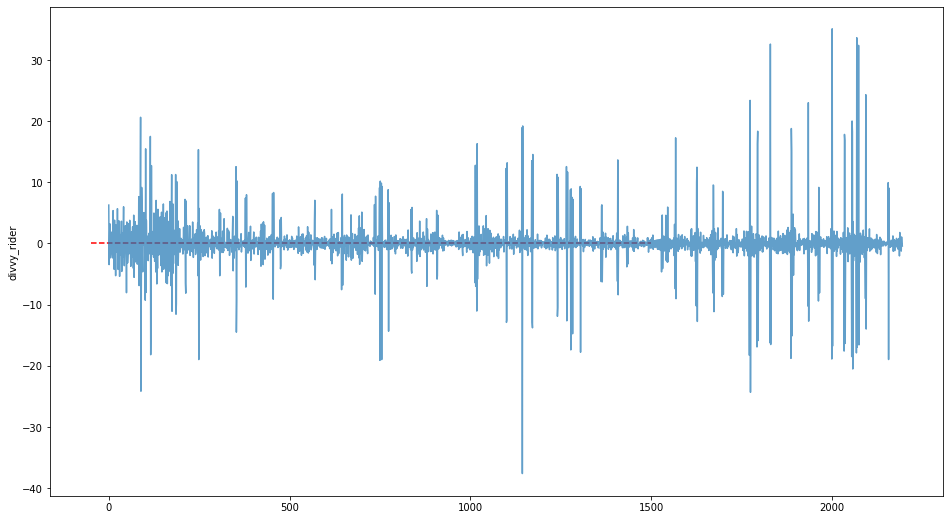

In [21]:
#Close 에 있는 데이터들을 t-1기로 한칸씩 미룸
brent_sta = wti["Close"].to_frame(name="Close") # 데이터의 행을 역순으로 뒤집는 부분 
brent_sta["lag_1"] = brent_sta["Close"].shift(periods=1)

# t - (t-1)를 통해 차분
brent_sta['Close2'] = brent_sta['Close'] - brent_sta['lag_1'] 
brent_sta['Close3'] = brent_sta['Close'].diff(1)

#결측치 드랍
brent_sta.dropna(inplace=True)
brent_sta

#검증
adf_test(brent_sta['Close2'])
kpss_test(brent_sta['Close2'])

diff_brent = brent_sta['Close2'].diff(1).dropna()

# 표 그리기
plt.figure(figsize=(16,9))
plt.plot(diff_brent.values, alpha=.7)
plt.hlines(y=diff_brent.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed')
plt.ylabel('divvy_rider')
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.258796e+00
p-value                        9.514707e-14
Lags Used                      2.600000e+01
Number of Observations Used    2.170000e+03
Critical Value (1%)           -3.962948e+00
Critical Value (5%)           -3.412515e+00
Critical Value (10%)          -3.128242e+00
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.032704
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


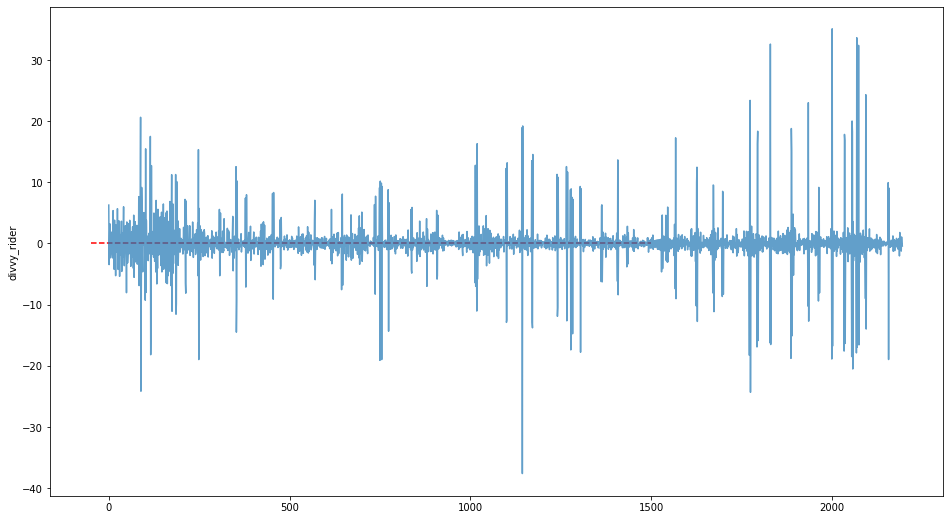

In [22]:
#Close 에 있는 데이터들을 t-1기로 한칸씩 미룸
dubai_sta = wti["Close"].to_frame(name="Close") # 데이터의 행을 역순으로 뒤집는 부분 
dubai_sta["lag_1"] = dubai_sta["Close"].shift(periods=1)

# t - (t-1)를 통해 차분
dubai_sta['Close2'] = dubai_sta['Close'] - dubai_sta['lag_1'] 
dubai_sta['Close3'] = dubai_sta['Close'].diff(1)

#결측치 드랍
dubai_sta.dropna(inplace=True)
dubai_sta

#검증
adf_test(dubai_sta['Close2'])
kpss_test(dubai_sta['Close2'])

diff_dubai = dubai_sta['Close2'].diff(1).dropna()

# 표 그리기
plt.figure(figsize=(16,9))
plt.plot(diff_dubai.values, alpha=.7)
plt.hlines(y=diff_dubai.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed')
plt.ylabel('divvy_rider')
plt.show()

In [23]:
oil_list2 = [wti_sta, dubai_sta, brent_sta]
oil_list2_names = ['WTI', 'Dubai', 'Brent']

for i in oil_list2:
  i = i[::-1]
  i.reset_index(drop=True, inplace=True)
  print(i)

      Close  lag_1  Close2  Close3
0     88.36  88.23    0.13    0.13
1     88.23  87.68    0.55    0.55
2     87.68  87.28    0.40    0.40
3     87.28  87.94   -0.66   -0.66
4     87.94  87.35    0.59    0.59
...     ...    ...     ...     ...
2192  87.90  86.53    1.37    1.37
2193  86.53  88.37   -1.84   -1.84
2194  88.37  90.00   -1.63   -1.63
2195  90.00  88.17    1.83    1.83
2196  88.17  92.61   -4.44   -4.44

[2197 rows x 4 columns]
      Close  lag_1  Close2  Close3
0     88.36  88.23    0.13    0.13
1     88.23  87.68    0.55    0.55
2     87.68  87.28    0.40    0.40
3     87.28  87.94   -0.66   -0.66
4     87.94  87.35    0.59    0.59
...     ...    ...     ...     ...
2192  87.90  86.53    1.37    1.37
2193  86.53  88.37   -1.84   -1.84
2194  88.37  90.00   -1.63   -1.63
2195  90.00  88.17    1.83    1.83
2196  88.17  92.61   -4.44   -4.44

[2197 rows x 4 columns]
      Close  lag_1  Close2  Close3
0     88.36  88.23    0.13    0.13
1     88.23  87.68    0.55    0.55
2    

In [24]:
# 불필요한 칼럼 삭제

for i in oil_list2:
  i.drop(['Close','lag_1','Close3'], axis=1, inplace=True)

In [25]:
for i in oil_list2:
  i['Close2'] = i['Close2'].astype(float)

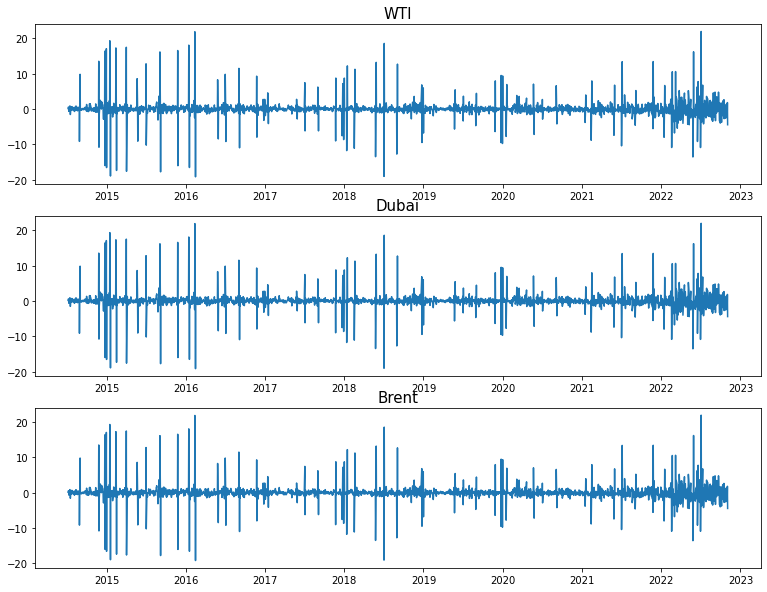

In [26]:
# 원유 3종 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(13,10))
for i,j in zip(range(1,4), oil_list2):
  plt.subplot(3,1,i)
  plt.title("%s" % oil_list2_names[i-1], size = 15)
  plt.plot(j)


In [27]:
# 가중치 계산식에 맞게 기준유가 변수 정의

oil_price = 0.8 * dubai_sta + 0.15 * brent_sta + 0.05 * wti_sta

In [28]:
oil_price

,Close2
Date,
2022-11-03,-4.44
2022-11-02,1.83
2022-11-01,-1.63
2022-10-31,-1.84
2022-10-28,1.37
...,...
2014-07-14,0.59
2014-07-11,-0.66
2014-07-10,0.40


In [29]:
oil_price.isnull().sum()

Close2    0
dtype: int64

In [30]:
# 결측치 제거
oil_price.dropna(axis=0, inplace=True)

In [31]:
oil_price

,Close2
Date,
2022-11-03,-4.44
2022-11-02,1.83
2022-11-01,-1.63
2022-10-31,-1.84
2022-10-28,1.37
...,...
2014-07-14,0.59
2014-07-11,-0.66
2014-07-10,0.40


In [32]:

oil_price.rename(columns={'Close2' : 'Close'}, inplace=True)

In [33]:
oil_price

,Close
Date,
2022-11-03,-4.44
2022-11-02,1.83
2022-11-01,-1.63
2022-10-31,-1.84
2022-10-28,1.37
...,...
2014-07-14,0.59
2014-07-11,-0.66
2014-07-10,0.40


In [34]:
oil_price = oil_price[::-1]
oil_price

,Close
Date,
2014-07-08,0.13
2014-07-09,0.55
2014-07-10,0.40
2014-07-11,-0.66
2014-07-14,0.59
...,...
2022-10-28,1.37
2022-10-31,-1.84
2022-11-01,-1.63


Text(0, 0.5, 'Oil Price')

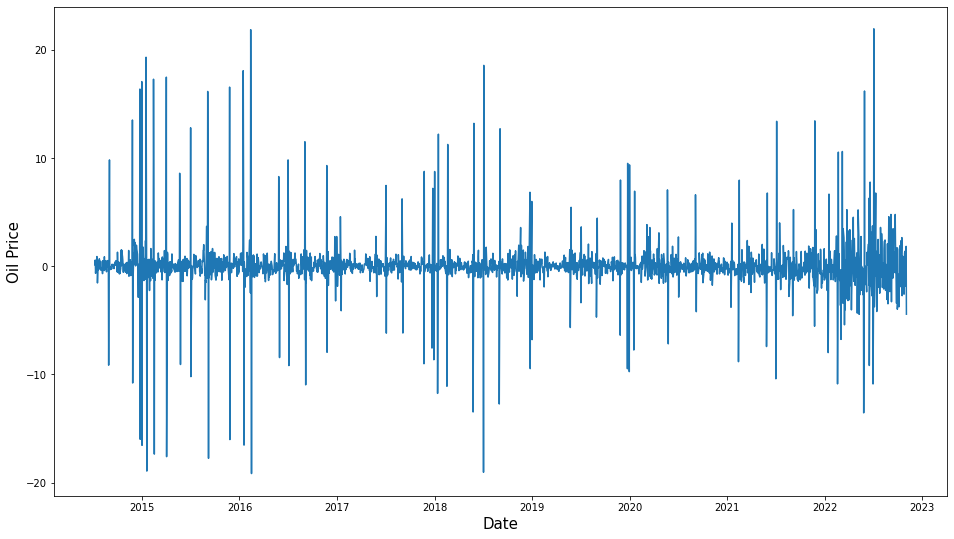

In [35]:
# 기준유가 시각화

plt.figure(figsize=(16,9))
plt.plot(oil_price)
plt.xlabel('Date', size = 15)
plt.ylabel('Oil Price', size = 15)

### S&P 500

In [36]:
df_SP500 = fdr.DataReader('US500', '2014-07-08')

In [37]:
df_SP500.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [38]:
df_SP500.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace = True)
df_SP500

,Close
Date,
2014-07-08,1963.709961
2014-07-09,1972.829956
2014-07-10,1964.680054
2014-07-11,1967.569946
2014-07-14,1977.099976
...,...
2022-11-01,3856.100098
2022-11-02,3759.689941
2022-11-03,3719.889893


In [39]:
df_SP500 = df_SP500[::-1]
df_SP500

,Close
Date,
2022-11-07,3806.800049
2022-11-04,3770.550049
2022-11-03,3719.889893
2022-11-02,3759.689941
2022-11-01,3856.100098
...,...
2014-07-14,1977.099976
2014-07-11,1967.569946
2014-07-10,1964.680054


In [40]:
df_SP500.isnull().sum()

Close    0
dtype: int64

In [41]:
adf_test(df_SP500)
kpss_test(df_SP500)

Results of Dickey-Fuller Test:
Test Statistic                   -2.703551
p-value                           0.234611
Lags Used                        11.000000
Number of Observations Used    2089.000000
Critical Value (1%)              -3.963110
Critical Value (5%)              -3.412594
Critical Value (10%)             -3.128289
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.
Results of KPSS Test:
Test Statistic            0.815392
p-value                   0.010000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Results of Dickey-Fuller Test:


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Test Statistic                -9.479502e+00
p-value                        3.082424e-14
Lags Used                      2.600000e+01
Number of Observations Used    2.073000e+03
Critical Value (1%)           -3.963144e+00
Critical Value (5%)           -3.412610e+00
Critical Value (10%)          -3.128298e+00
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.067751
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


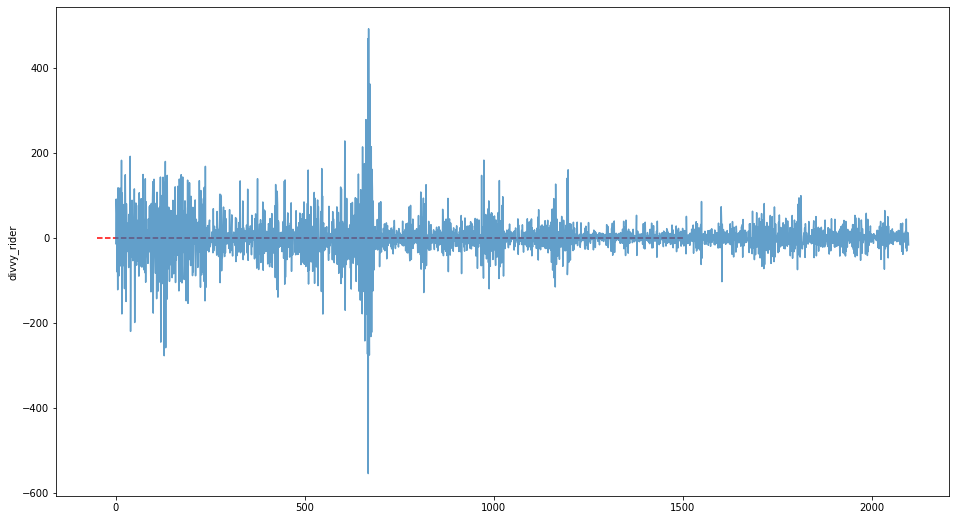

In [42]:
#Close 에 있는 데이터들을 t-1기로 한칸씩 미룸
SP500_sta = df_SP500["Close"].to_frame(name="Close") # 데이터의 행을 역순으로 뒤집는 부분 
SP500_sta["lag_1"] = SP500_sta["Close"].shift(periods=1)

# t - (t-1)를 통해 차분
SP500_sta['Close2'] = SP500_sta['Close'] - SP500_sta['lag_1'] 
SP500_sta['Close3'] = SP500_sta['Close'].diff(1)

#결측치 드랍
SP500_sta.dropna(inplace=True)
SP500_sta

#검증
adf_test(SP500_sta['Close2'])
kpss_test(SP500_sta['Close2'])

diff_aviation = SP500_sta['Close2'].diff(1).dropna()

# 표 그리기
plt.figure(figsize=(16,9))
plt.plot(diff_aviation.values, alpha=.7)
plt.hlines(y=diff_aviation.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed')
plt.ylabel('divvy_rider')
plt.show()

In [43]:
SP500_sta

,Close,lag_1,Close2,Close3
Date,,,,
2022-11-04,3770.550049,3806.800049,-36.250000,-36.250000
2022-11-03,3719.889893,3770.550049,-50.660156,-50.660156
2022-11-02,3759.689941,3719.889893,39.800048,39.800048
2022-11-01,3856.100098,3759.689941,96.410157,96.410157
2022-10-31,3871.979980,3856.100098,15.879882,15.879882
...,...,...,...,...
2014-07-14,1977.099976,1973.280029,3.819947,3.819947
2014-07-11,1967.569946,1977.099976,-9.530030,-9.530030
2014-07-10,1964.680054,1967.569946,-2.889892,-2.889892


In [44]:
SP500_sta.drop(['Close','lag_1','Close3'], axis=1, inplace=True)

In [45]:

SP500_sta.rename(columns={'Close2' : 'Close'}, inplace=True)

In [46]:
SP500_sta

,Close
Date,
2022-11-04,-36.250000
2022-11-03,-50.660156
2022-11-02,39.800048
2022-11-01,96.410157
2022-10-31,15.879882
...,...
2014-07-14,3.819947
2014-07-11,-9.530030
2014-07-10,-2.889892


In [47]:
SP500_sta = SP500_sta[::-1]
SP500_sta

,Close
Date,
2014-07-08,-9.119995
2014-07-09,8.149902
2014-07-10,-2.889892
2014-07-11,-9.530030
2014-07-14,3.819947
...,...
2022-10-31,15.879882
2022-11-01,96.410157
2022-11-02,39.800048


### USD/KRW 환율

In [48]:
df_USD = fdr.DataReader('USD/KRW', start = '2014-07-08')

In [49]:
df_USD

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-08,1010.599976,1011.500000,1008.950012,1010.599976,1010.599976,0.0
2014-07-09,1010.599976,1011.900024,1010.000000,1010.799988,1010.799988,0.0
2014-07-10,1008.500000,1012.700012,1008.500000,1011.000000,1011.000000,0.0
2014-07-11,1012.299988,1019.500000,1012.299988,1012.200012,1012.200012,0.0
2014-07-14,1017.049988,1019.429993,1016.000000,1018.500000,1018.500000,0.0
...,...,...,...,...,...,...
2022-11-02,1416.599976,1420.400024,1412.359985,1416.599976,1416.599976,0.0
2022-11-03,1423.099976,1427.949951,1417.089966,1423.099976,1423.099976,0.0
2022-11-04,1423.650024,1428.939941,1404.010010,1423.650024,1423.650024,0.0


In [50]:
df_USD.isnull().sum()

Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [51]:
df_USD[ df_USD['Close'].isnull() ]    # 결측치 자리 찾기

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-07-11,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-22,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_USD = df_USD.dropna(axis=0)   #결측치 제외하기

In [53]:
df_USD.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace = True)
df_USD

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Close
Date,
2014-07-08,1010.599976
2014-07-09,1010.799988
2014-07-10,1011.000000
2014-07-11,1012.200012
2014-07-14,1018.500000
...,...
2022-11-02,1416.599976
2022-11-03,1423.099976
2022-11-04,1423.650024


In [54]:
df_USD = df_USD[::-1]
df_USD

,Close
Date,
2022-11-08,1378.949951
2022-11-07,1402.109985
2022-11-04,1423.650024
2022-11-03,1423.099976
2022-11-02,1416.599976
...,...
2014-07-14,1018.500000
2014-07-11,1012.200012
2014-07-10,1011.000000


In [55]:
df_USD.isnull().sum()

Close    0
dtype: int64

In [56]:
adf_test(df_USD)
kpss_test(df_USD)

Results of Dickey-Fuller Test:
Test Statistic                   -3.349646
p-value                           0.058488
Lags Used                         1.000000
Number of Observations Used    2171.000000
Critical Value (1%)              -3.962946
Critical Value (5%)              -3.412514
Critical Value (10%)             -3.128242
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.484376
p-value                   0.010000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Results of Dickey-Fuller Test:


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Test Statistic                  -51.565036
p-value                           0.000000
Lags Used                         0.000000
Number of Observations Used    2171.000000
Critical Value (1%)              -3.962946
Critical Value (5%)              -3.412514
Critical Value (10%)             -3.128242
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.116006
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


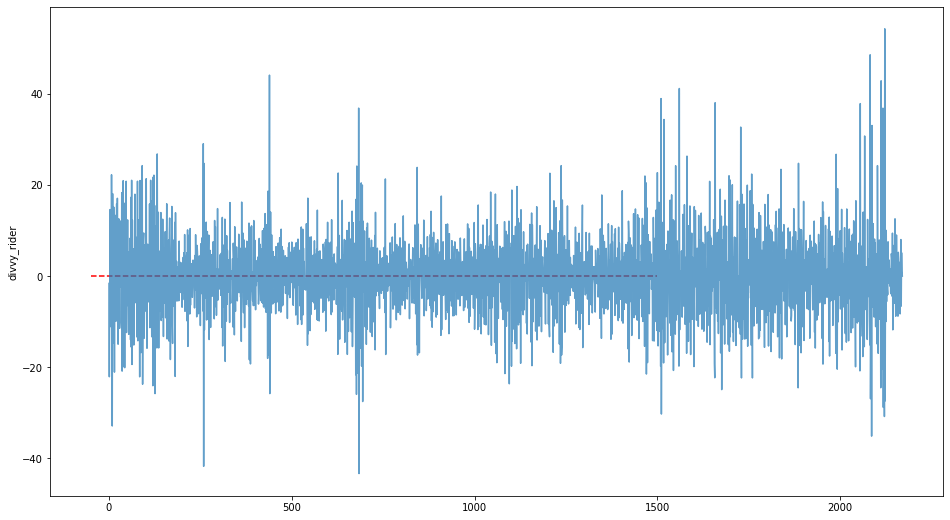

In [57]:
#Close 에 있는 데이터들을 t-1기로 한칸씩 미룸
df_USD_sta = df_USD["Close"].to_frame(name="Close") # 데이터의 행을 역순으로 뒤집는 부분 
df_USD_sta["lag_1"] = df_USD_sta["Close"].shift(periods=1)

# t - (t-1)를 통해 차분
df_USD_sta['Close2'] = df_USD_sta['Close'] - df_USD_sta['lag_1'] 
df_USD_sta['Close3'] = df_USD_sta['Close'].diff(1)

#결측치 드랍
df_USD_sta.dropna(inplace=True)
df_USD_sta

#검증
adf_test(df_USD_sta['Close2'])
kpss_test(df_USD_sta['Close2'])

diff_aviation = df_USD_sta['Close2'].diff(1).dropna()

# 표 그리기
plt.figure(figsize=(16,9))
plt.plot(diff_aviation.values, alpha=.7)
plt.hlines(y=diff_aviation.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed')
plt.ylabel('divvy_rider')
plt.show()

In [58]:
df_USD_sta

,Close,lag_1,Close2,Close3
Date,,,,
2022-11-07,1402.109985,1378.949951,23.160034,23.160034
2022-11-04,1423.650024,1402.109985,21.540039,21.540039
2022-11-03,1423.099976,1423.650024,-0.550048,-0.550048
2022-11-02,1416.599976,1423.099976,-6.500000,-6.500000
2022-11-01,1424.670044,1416.599976,8.070068,8.070068
...,...,...,...,...
2014-07-14,1018.500000,1018.200012,0.299988,0.299988
2014-07-11,1012.200012,1018.500000,-6.299988,-6.299988
2014-07-10,1011.000000,1012.200012,-1.200012,-1.200012


In [59]:
df_USD_sta.drop(['Close','lag_1','Close3'], axis=1, inplace=True)

In [60]:

df_USD_sta.rename(columns={'Close2' : 'Close'}, inplace=True)

In [61]:
df_USD_sta

,Close
Date,
2022-11-07,23.160034
2022-11-04,21.540039
2022-11-03,-0.550048
2022-11-02,-6.500000
2022-11-01,8.070068
...,...
2014-07-14,0.299988
2014-07-11,-6.299988
2014-07-10,-1.200012


In [62]:
df_USD_sta = df_USD_sta[::-1]
df_USD_sta

,Close
Date,
2014-07-08,-0.200012
2014-07-09,-0.200012
2014-07-10,-1.200012
2014-07-11,-6.299988
2014-07-14,0.299988
...,...
2022-11-01,8.070068
2022-11-02,-6.500000
2022-11-03,-0.550048


### 다우존스

In [63]:
#다우존스 가격
df_DJI = fdr.DataReader('DJI', start  = '2014-07-08')

In [64]:
df_DJI

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-08,17022.089844,17022.089844,16874.789063,16906.619141,16906.619141,75250000
2014-07-09,16916.830078,16998.949219,16913.810547,16985.609375,16985.609375,67120000
2014-07-10,16980.349609,16980.349609,16805.380859,16915.070313,16915.070313,67510000
2014-07-11,16918.310547,16949.460938,16860.300781,16943.810547,16943.810547,61000000
2014-07-14,16950.929688,17088.429688,16950.929688,17055.419922,17055.419922,60570000
...,...,...,...,...,...,...
2022-11-01,32862.789063,32975.480469,32485.230469,32653.199219,32653.199219,323210000
2022-11-02,32576.279297,33071.929688,32139.769531,32147.759766,32147.759766,398430000
2022-11-03,31985.050781,32185.710938,31727.050781,32001.250000,32001.250000,354440000


In [65]:
df_DJI.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [66]:
df_DJI.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace = True)
df_DJI

,Close
Date,
2014-07-08,16906.619141
2014-07-09,16985.609375
2014-07-10,16915.070313
2014-07-11,16943.810547
2014-07-14,17055.419922
...,...
2022-11-01,32653.199219
2022-11-02,32147.759766
2022-11-03,32001.250000


In [67]:
df_DJI = df_DJI[::-1]
df_DJI

,Close
Date,
2022-11-07,32827.000000
2022-11-04,32403.220703
2022-11-03,32001.250000
2022-11-02,32147.759766
2022-11-01,32653.199219
...,...
2014-07-14,17055.419922
2014-07-11,16943.810547
2014-07-10,16915.070313


In [68]:
df_DJI.isnull().sum()

Close    0
dtype: int64

In [69]:
adf_test(df_DJI)
kpss_test(df_DJI)

Results of Dickey-Fuller Test:
Test Statistic                   -3.359573
p-value                           0.057028
Lags Used                        10.000000
Number of Observations Used    2090.000000
Critical Value (1%)              -3.963108
Critical Value (5%)              -3.412593
Critical Value (10%)             -3.128288
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.272589
p-value                   0.010000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Results of Dickey-Fuller Test:


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Test Statistic                -1.447374e+01
p-value                        4.549019e-22
Lags Used                      9.000000e+00
Number of Observations Used    2.090000e+03
Critical Value (1%)           -3.963108e+00
Critical Value (5%)           -3.412593e+00
Critical Value (10%)          -3.128288e+00
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.033543
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


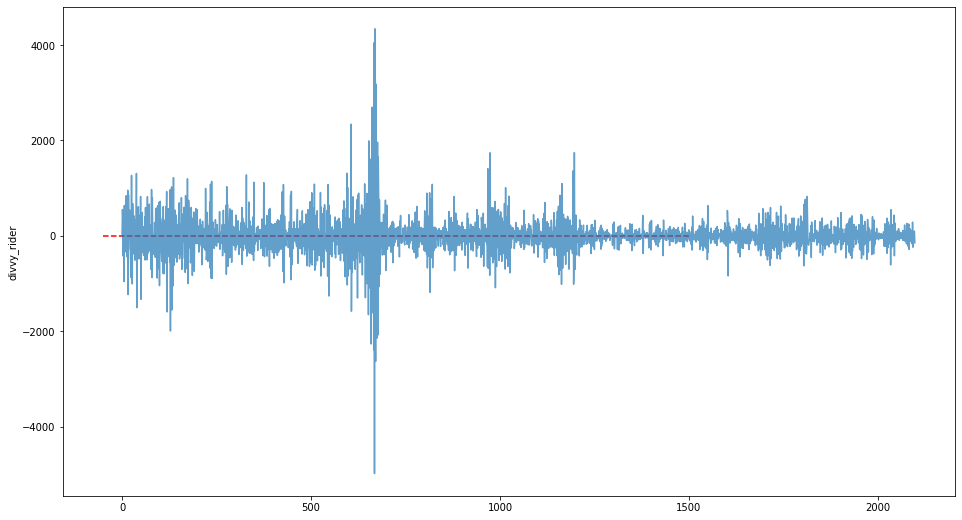

In [70]:
#Close 에 있는 데이터들을 t-1기로 한칸씩 미룸
df_DJI_sta = df_DJI["Close"].to_frame(name="Close") # 데이터의 행을 역순으로 뒤집는 부분 
df_DJI_sta["lag_1"] = df_DJI_sta["Close"].shift(periods=1)

# t - (t-1)를 통해 차분
df_DJI_sta['Close2'] = df_DJI_sta['Close'] - df_DJI_sta['lag_1'] 
df_DJI_sta['Close3'] = df_DJI_sta['Close'].diff(1)

#결측치 드랍
df_DJI_sta.dropna(inplace=True)
df_DJI_sta

#검증
adf_test(df_DJI_sta['Close2'])
kpss_test(df_DJI_sta['Close2'])

diff_aviation = df_DJI_sta['Close2'].diff(1).dropna()

# 표 그리기
plt.figure(figsize=(16,9))
plt.plot(diff_aviation.values, alpha=.7)
plt.hlines(y=diff_aviation.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed')
plt.ylabel('divvy_rider')
plt.show()

In [71]:
df_DJI_sta

,Close,lag_1,Close2,Close3
Date,,,,
2022-11-04,32403.220703,32827.000000,-423.779297,-423.779297
2022-11-03,32001.250000,32403.220703,-401.970703,-401.970703
2022-11-02,32147.759766,32001.250000,146.509766,146.509766
2022-11-01,32653.199219,32147.759766,505.439453,505.439453
2022-10-31,32732.949219,32653.199219,79.750000,79.750000
...,...,...,...,...
2014-07-14,17055.419922,17060.679688,-5.259766,-5.259766
2014-07-11,16943.810547,17055.419922,-111.609375,-111.609375
2014-07-10,16915.070313,16943.810547,-28.740234,-28.740234


In [72]:
df_DJI_sta.drop(['Close','lag_1','Close3'], axis=1, inplace=True)

In [73]:

df_DJI_sta.rename(columns={'Close2' : 'Close'}, inplace=True)

In [74]:
df_DJI_sta

,Close
Date,
2022-11-04,-423.779297
2022-11-03,-401.970703
2022-11-02,146.509766
2022-11-01,505.439453
2022-10-31,79.750000
...,...
2014-07-14,-5.259766
2014-07-11,-111.609375
2014-07-10,-28.740234


In [75]:
df_DJI_sta = df_DJI_sta[::-1]
df_DJI_sta

,Close
Date,
2014-07-08,-78.990234
2014-07-09,70.539062
2014-07-10,-28.740234
2014-07-11,-111.609375
2014-07-14,-5.259766
...,...
2022-10-31,79.750000
2022-11-01,505.439453
2022-11-02,146.509766


### **TARGET DATA** 항공업 주가 데이터
- 항공사 전반적 추세 확인 위해 전체 항공 여객 운송업 데이터 이용
- 문제점: 에어부산의 가장 최신 데이터가 2018년 12월 27일이라 그때부터의 데이터를 합함

**항공 여객 운송업 종목 모으기**

finance data reader 데이터가 변경되기 전 (2022.10.10 기준),

"항공 여객 운송업" 부문 코드 찾은 내용

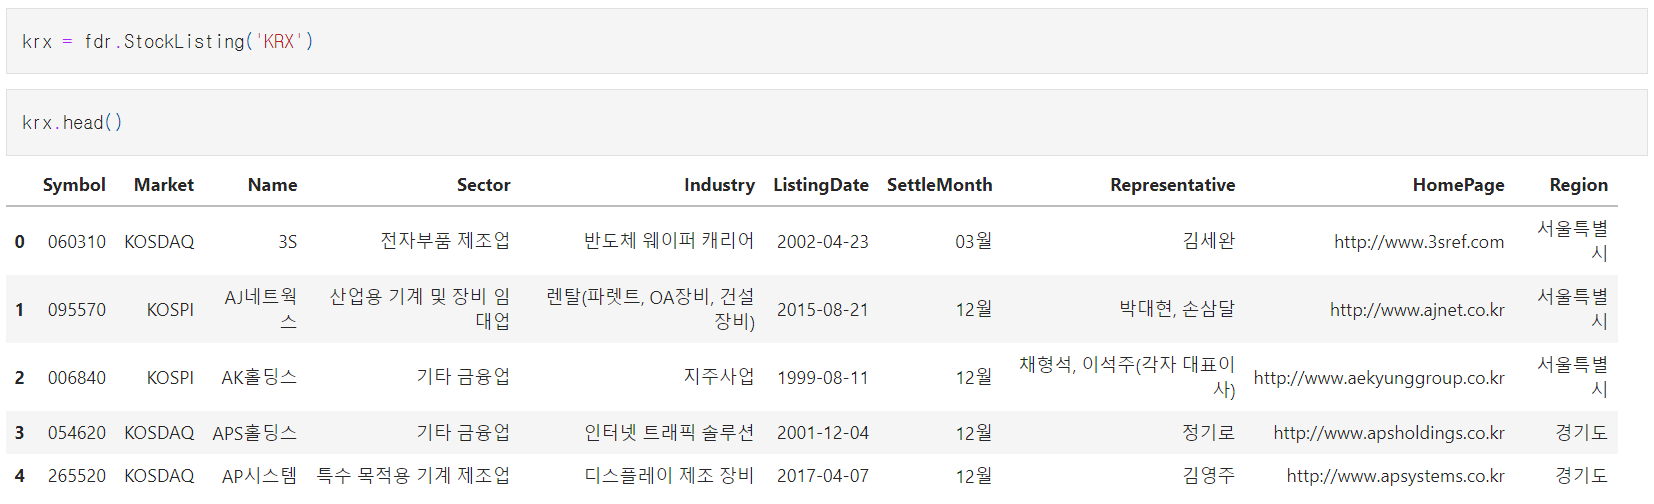

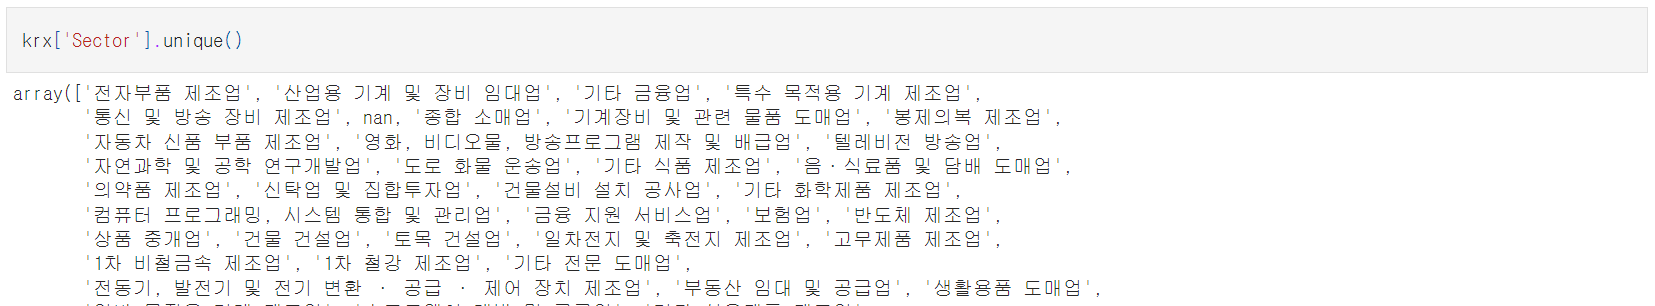

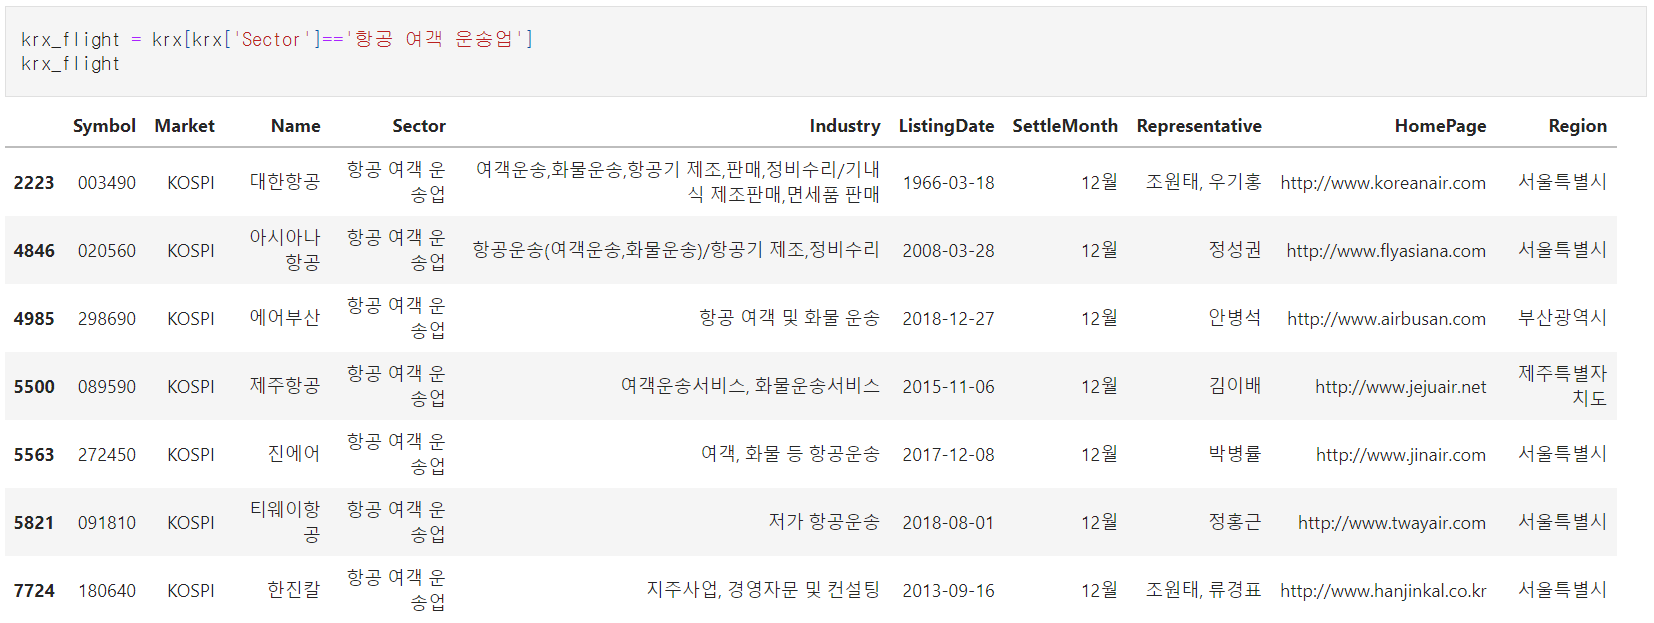

위에서 찾은 Symbol을 토대로 현재 변경된 (2022-10-31 기준) 데이터에서 항공 여객 운송업 부문 추출

In [76]:
# 위와 같은 데이터 사용
# !pip install -U finance-datareader

In [77]:
krx = fdr.StockListing('KRX')

In [78]:
krx.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,61800,1,1600,2.66,60500,61900,60500,18273898,1123976801804,368932561590000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,588000,1,1000,0.17,590000,590000,570000,367102,213455513000,137592000000000,234000000,STK
2,207940,KR7207940008,삼성바이오로직스,KOSPI,,900000,1,17000,1.93,889000,906000,885000,73570,65873201000,64056600000000,71174000,STK
3,000660,KR7000660001,SK하이닉스,KOSPI,,87700,1,1200,1.39,87600,89000,87400,2799575,246892477700,63845807410500,728002365,STK
4,006400,KR7006400006,삼성SDI,KOSPI,,730000,2,-10000,-1.35,734000,739000,711000,357230,258456280696,50198106900000,68764530,STK


In [79]:
krair = fdr.DataReader('003490')
asair = fdr.DataReader('020560')
buair = fdr.DataReader('298690')
jejuair = fdr.DataReader('089590')
jinair = fdr.DataReader('272450')
twair = fdr.DataReader('091810')
hjkair = fdr.DataReader('180640')

In [80]:
asair.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')

In [81]:
list = [krair,asair,buair,jejuair,jinair,twair,hjkair]
for i in list:
    i.drop(['Open', 'High', 'Low', 'Change'],axis=1,inplace=True)

In [82]:
# 항공사 모은 변수 aviation 정의
aviation = 0.71*krair + 0.7*asair + 0.22*hjkair

In [83]:
# 에어부산 데이터 이전인 2018-12-26까지만 결측치, 이후에는 결측치 없는 것 확인

aviation[ aviation['Close'].isnull() ].tail(10)

,Close,Volume
Date,,
2013-09-02,NaN,NaN
2013-09-03,NaN,NaN
2013-09-04,NaN,NaN
2013-09-05,NaN,NaN
2013-09-06,NaN,NaN
2013-09-09,NaN,NaN
2013-09-10,NaN,NaN
2013-09-11,NaN,NaN
2013-09-12,NaN,NaN


In [84]:
# 따라서 전체 항공사 주가 중 2018-12-27 자료만 사용
aviation = aviation['2014-07-08':]

In [85]:
aviation

,Close,Volume
Date,,
2014-07-08,34994.00,262130.42
2014-07-09,34657.86,223468.36
2014-07-10,34623.84,234303.35
2014-07-11,34364.45,305370.10
2014-07-14,34642.70,240927.11
...,...,...
2022-11-02,32918.50,1299782.35
2022-11-03,32690.00,1143552.69
2022-11-04,33754.50,2638526.24


In [86]:
aviation.isnull().sum() # 마지막으로 결측치 없는 것 확인

Close     0
Volume    0
dtype: int64

#### 정상성 부여를 위해 거래량과 주가를 각가 데이터 프레임에 넣는다

In [87]:
aviation_close = pd.DataFrame(aviation['Close'])
aviation_close

,Close
Date,
2014-07-08,34994.00
2014-07-09,34657.86
2014-07-10,34623.84
2014-07-11,34364.45
2014-07-14,34642.70
...,...
2022-11-02,32918.50
2022-11-03,32690.00
2022-11-04,33754.50


In [88]:
aviation_close = aviation_close[::-1]
aviation_close

,Close
Date,
2022-11-08,34597.50
2022-11-07,34117.00
2022-11-04,33754.50
2022-11-03,32690.00
2022-11-02,32918.50
...,...
2014-07-14,34642.70
2014-07-11,34364.45
2014-07-10,34623.84


In [89]:
aviation_volume = pd.DataFrame(aviation['Volume'])
aviation_volume

,Volume
Date,
2014-07-08,262130.42
2014-07-09,223468.36
2014-07-10,234303.35
2014-07-11,305370.10
2014-07-14,240927.11
...,...
2022-11-02,1299782.35
2022-11-03,1143552.69
2022-11-04,2638526.24


In [90]:
aviation_volume = aviation_volume[::-1]
aviation_volume

,Volume
Date,
2022-11-08,1366908.43
2022-11-07,1269589.87
2022-11-04,2638526.24
2022-11-03,1143552.69
2022-11-02,1299782.35
...,...
2014-07-14,240927.11
2014-07-11,305370.10
2014-07-10,234303.35


#### 정상성 부여

##### aviation_close 정상성 부여

In [91]:
adf_test(aviation_close)
kpss_test(aviation_close)

Results of Dickey-Fuller Test:
Test Statistic                   -3.418358
p-value                           0.048983
Lags Used                         1.000000
Number of Observations Used    2049.000000
Critical Value (1%)              -3.963195
Critical Value (5%)              -3.412635
Critical Value (10%)             -3.128313
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.659913
p-value                   0.010000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Results of Dickey-Fuller Test:
Test Statistic                  -43.855049
p-value                           0.000000
Lags Used                         0.000000
Number of Observations Used    2049.000000
Critical Value (1%)              -3.963195
Critical Value (5%)              -3.412635
Critical Value (10%)             -3.128313
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.042394
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


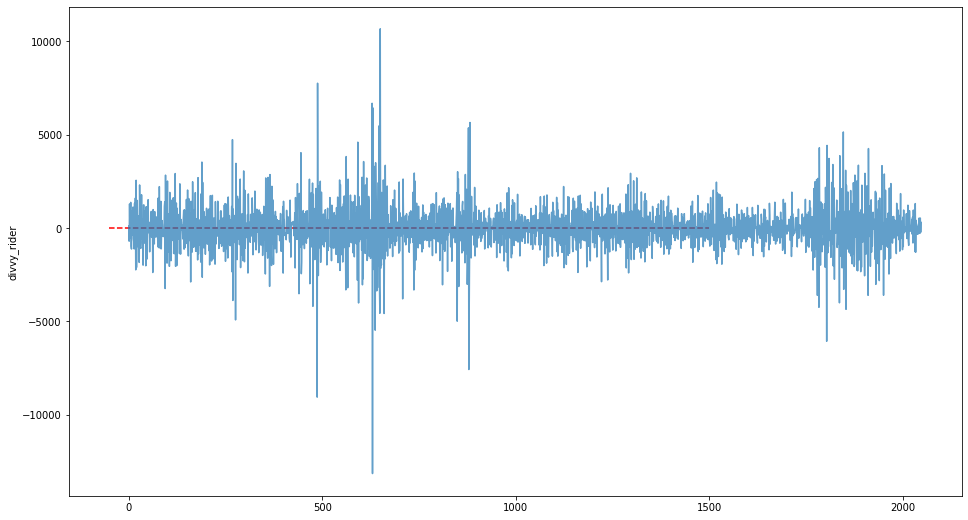

In [92]:
#Close 에 있는 데이터들을 t-1기로 한칸씩 미룸
aviation_sta1 = aviation_close["Close"].to_frame(name="Close") # 데이터의 행을 역순으로 뒤집는 부분 
aviation_sta1["lag_1"] = aviation_sta1["Close"].shift(periods=1)

# t - (t-1)를 통해 차분
aviation_sta1['Close2'] = aviation_sta1['Close'] - aviation_sta1['lag_1'] 
aviation_sta1['Close3'] = aviation_sta1['Close'].diff(1)

#결측치 드랍
aviation_sta1.dropna(inplace=True)
aviation_sta1

#검증
adf_test(aviation_sta1['Close2'])
kpss_test(aviation_sta1['Close2'])

diff_aviation = aviation_sta1['Close2'].diff(1).dropna()

# 표 그리기
plt.figure(figsize=(16,9))
plt.plot(diff_aviation.values, alpha=.7)
plt.hlines(y=diff_aviation.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed')
plt.ylabel('divvy_rider')
plt.show()

In [93]:
aviation_sta1

,Close,lag_1,Close2,Close3
Date,,,,
2022-11-07,34117.00,34597.50,-480.50,-480.50
2022-11-04,33754.50,34117.00,-362.50,-362.50
2022-11-03,32690.00,33754.50,-1064.50,-1064.50
2022-11-02,32918.50,32690.00,228.50,228.50
2022-11-01,32935.50,32918.50,17.00,17.00
...,...,...,...,...
2014-07-14,34642.70,34635.51,7.19,7.19
2014-07-11,34364.45,34642.70,-278.25,-278.25
2014-07-10,34623.84,34364.45,259.39,259.39


In [94]:
aviation_sta1.drop(['Close','lag_1','Close3'], axis=1, inplace=True)

In [95]:

aviation_sta1.rename(columns={'Close2' : 'Close'}, inplace=True)

In [96]:
aviation_sta1

,Close
Date,
2022-11-07,-480.50
2022-11-04,-362.50
2022-11-03,-1064.50
2022-11-02,228.50
2022-11-01,17.00
...,...
2014-07-14,7.19
2014-07-11,-278.25
2014-07-10,259.39


##### aviation_volume 정상성 부여

In [97]:
adf_test(aviation_volume)
kpss_test(aviation_volume)

Results of Dickey-Fuller Test:
Test Statistic                -9.047822e+00
p-value                        2.830373e-13
Lags Used                      1.100000e+01
Number of Observations Used    2.039000e+03
Critical Value (1%)           -3.963217e+00
Critical Value (5%)           -3.412645e+00
Critical Value (10%)          -3.128319e+00
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.2441
p-value                   0.0100
Lags Used                26.0000
Critical Value (10%)      0.1190
Critical Value (5%)       0.1460
Critical Value (2.5%)     0.1760
Critical Value (1%)       0.2160
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Results of Dickey-Fuller Test:
Test Statistic                -1.305596e+01
p-value                        1.154145e-20
Lags Used                      2.600000e+01
Number of Observations Used    2.023000e+03
Critical Value (1%)           -3.963252e+00
Critical Value (5%)           -3.412662e+00
Critical Value (10%)          -3.128329e+00
dtype: float64
정상시계열이 아니라는 귀무가설을 20.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.
Results of KPSS Test:
Test Statistic            0.007104
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


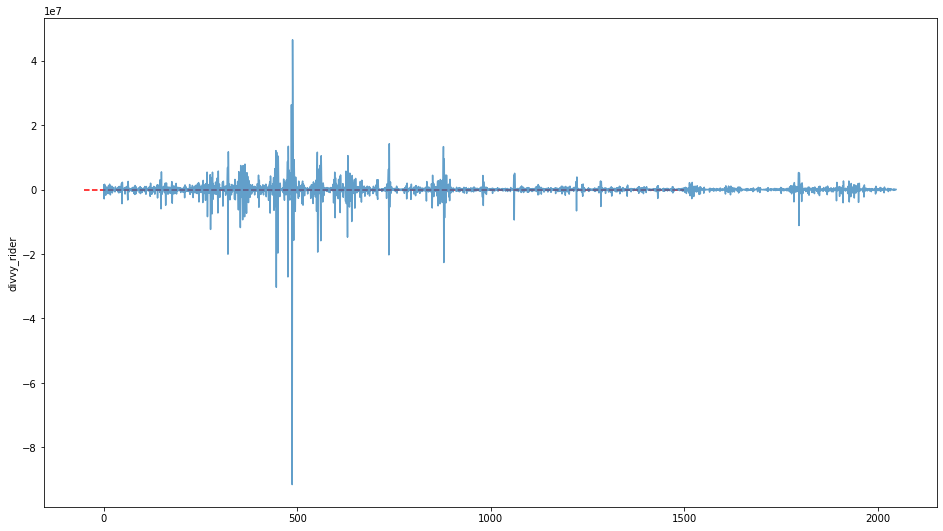

In [98]:
#Close 에 있는 데이터들을 t-1기로 한칸씩 미룸
aviation_sta2 = aviation_volume["Volume"].to_frame(name="Volume") # 데이터의 행을 역순으로 뒤집는 부분 
aviation_sta2["lag_1"] = aviation_sta2["Volume"].shift(periods=1)

# t - (t-1)를 통해 차분
aviation_sta2['Volume2'] = aviation_sta2['Volume'] - aviation_sta2['lag_1'] 
aviation_sta2['Volume3'] = aviation_sta2['Volume'].diff(1)

#결측치 드랍
aviation_sta2.dropna(inplace=True)
aviation_sta2

#검증
adf_test(aviation_sta2['Volume2'])
kpss_test(aviation_sta2['Volume2'])

diff_aviation = aviation_sta2['Volume2'].diff(1).dropna()

# 표 그리기
plt.figure(figsize=(16,9))
plt.plot(diff_aviation.values, alpha=.7)
plt.hlines(y=diff_aviation.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed')
plt.ylabel('divvy_rider')
plt.show()

In [99]:
aviation_sta2

,Volume,lag_1,Volume2,Volume3
Date,,,,
2022-11-07,1269589.87,1366908.43,-97318.56,-97318.56
2022-11-04,2638526.24,1269589.87,1368936.37,1368936.37
2022-11-03,1143552.69,2638526.24,-1494973.55,-1494973.55
2022-11-02,1299782.35,1143552.69,156229.66,156229.66
2022-11-01,1091961.57,1299782.35,-207820.78,-207820.78
...,...,...,...,...
2014-07-14,240927.11,282625.81,-41698.70,-41698.70
2014-07-11,305370.10,240927.11,64442.99,64442.99
2014-07-10,234303.35,305370.10,-71066.75,-71066.75


In [100]:
aviation_sta2.drop(['Volume','lag_1','Volume3'], axis=1, inplace=True)

In [101]:

aviation_sta2.rename(columns={'Volume2' : 'Volume'}, inplace=True)

In [102]:
aviation_sta2

,Volume
Date,
2022-11-07,-97318.56
2022-11-04,1368936.37
2022-11-03,-1494973.55
2022-11-02,156229.66
2022-11-01,-207820.78
...,...
2014-07-14,-41698.70
2014-07-11,64442.99
2014-07-10,-71066.75


In [103]:
aviation_sta1

,Close
Date,
2022-11-07,-480.50
2022-11-04,-362.50
2022-11-03,-1064.50
2022-11-02,228.50
2022-11-01,17.00
...,...
2014-07-14,7.19
2014-07-11,-278.25
2014-07-10,259.39


#### 두개 데이터 다시 합치고 역순해 놓기

In [104]:
aviation_sta = pd.concat([aviation_sta1, aviation_sta2], axis=1)
aviation_sta

,Close,Volume
Date,,
2022-11-07,-480.50,-97318.56
2022-11-04,-362.50,1368936.37
2022-11-03,-1064.50,-1494973.55
2022-11-02,228.50,156229.66
2022-11-01,17.00,-207820.78
...,...,...
2014-07-14,7.19,-41698.70
2014-07-11,-278.25,64442.99
2014-07-10,259.39,-71066.75


In [105]:
aviation_sta = aviation_sta[::-1]
aviation_sta

,Close,Volume
Date,,
2014-07-08,336.14,38662.06
2014-07-09,34.02,-10834.99
2014-07-10,259.39,-71066.75
2014-07-11,-278.25,64442.99
2014-07-14,7.19,-41698.70
...,...,...
2022-11-01,17.00,-207820.78
2022-11-02,228.50,156229.66
2022-11-03,-1064.50,-1494973.55


# 2.데이터셋 필요한 형태로 만들기 (df_close)
: **날짜(Date), 변수 별 종가(close)** 데이터

Date / SP500 close / WTI close / USD close / DJI close

In [106]:
import pandas as pd

In [107]:
dfs = [aviation_sta, oil_price, SP500_sta, df_USD_sta, df_DJI_sta]

In [108]:
names = ['AVIATION', 'Volume', 'OIL PRICE', 'SP500', 'USD', 'DJI']

In [109]:
df_close = pd.concat(dfs, axis=1)
df_close

,Close,Volume,Close,Close,Close,Close
Date,,,,,,
2014-07-08,336.14,38662.06,0.13,-9.119995,-0.200012,-78.990234
2014-07-09,34.02,-10834.99,0.55,8.149902,-0.200012,70.539062
2014-07-10,259.39,-71066.75,0.40,-2.889892,-1.200012,-28.740234
2014-07-11,-278.25,64442.99,-0.66,-9.530030,-6.299988,-111.609375
2014-07-14,7.19,-41698.70,0.59,3.819947,0.299988,-5.259766
...,...,...,...,...,...,...
2022-11-01,17.00,-207820.78,-1.63,96.410157,8.070068,505.439453
2022-11-02,228.50,156229.66,1.83,39.800048,-6.500000,146.509766
2022-11-03,-1064.50,-1494973.55,-4.44,-50.660156,-0.550048,-401.970703


In [110]:
df_close.columns = names
df_close

,AVIATION,Volume,OIL PRICE,SP500,USD,DJI
Date,,,,,,
2014-07-08,336.14,38662.06,0.13,-9.119995,-0.200012,-78.990234
2014-07-09,34.02,-10834.99,0.55,8.149902,-0.200012,70.539062
2014-07-10,259.39,-71066.75,0.40,-2.889892,-1.200012,-28.740234
2014-07-11,-278.25,64442.99,-0.66,-9.530030,-6.299988,-111.609375
2014-07-14,7.19,-41698.70,0.59,3.819947,0.299988,-5.259766
...,...,...,...,...,...,...
2022-11-01,17.00,-207820.78,-1.63,96.410157,8.070068,505.439453
2022-11-02,228.50,156229.66,1.83,39.800048,-6.500000,146.509766
2022-11-03,-1064.50,-1494973.55,-4.44,-50.660156,-0.550048,-401.970703


In [111]:
# 결측치 있는 행 모아보기
df_close[df_close['AVIATION'].isnull() | df_close['OIL PRICE'].isnull() | df_close['SP500'].isnull() | df_close['USD'].isnull() | df_close['DJI'].isnull()]

,AVIATION,Volume,OIL PRICE,SP500,USD,DJI
Date,,,,,,
2014-08-15,NaN,NaN,-0.14,-16.679931,-0.500000,-175.830078
2014-09-01,370.22,199136.87,9.82,NaN,1.799988,NaN
2014-09-08,NaN,NaN,-0.14,13.100098,0.000000,97.550781
2014-09-09,NaN,NaN,-0.25,-7.250000,-10.000000,-54.841797
2014-09-10,NaN,NaN,-0.21,-1.760010,0.000000,19.710938
...,...,...,...,...,...,...
2022-09-12,NaN,NaN,0.61,177.720215,3.250000,1276.369141
2022-10-03,NaN,NaN,-2.80,-112.500000,5.890014,-825.429688
2022-10-10,NaN,NaN,1.87,23.549805,-12.369996,-36.308594


In [112]:
# 결측치 제거
df_close.dropna(axis = 0, inplace = True)

In [113]:
df_close

,AVIATION,Volume,OIL PRICE,SP500,USD,DJI
Date,,,,,,
2014-07-08,336.14,38662.06,0.13,-9.119995,-0.200012,-78.990234
2014-07-09,34.02,-10834.99,0.55,8.149902,-0.200012,70.539062
2014-07-10,259.39,-71066.75,0.40,-2.889892,-1.200012,-28.740234
2014-07-11,-278.25,64442.99,-0.66,-9.530030,-6.299988,-111.609375
2014-07-14,7.19,-41698.70,0.59,3.819947,0.299988,-5.259766
...,...,...,...,...,...,...
2022-10-28,843.50,-837746.60,1.37,29.080079,-1.000000,128.851562
2022-10-31,-533.50,890462.06,-1.84,15.879882,-3.020020,79.750000
2022-11-01,17.00,-207820.78,-1.63,96.410157,8.070068,505.439453


In [114]:
df_close.isnull().sum()

AVIATION     0
Volume       0
OIL PRICE    0
SP500        0
USD          0
DJI          0
dtype: int64

# 3.데이터 시각화해서 확인

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

Text(0, 0.5, 'price')

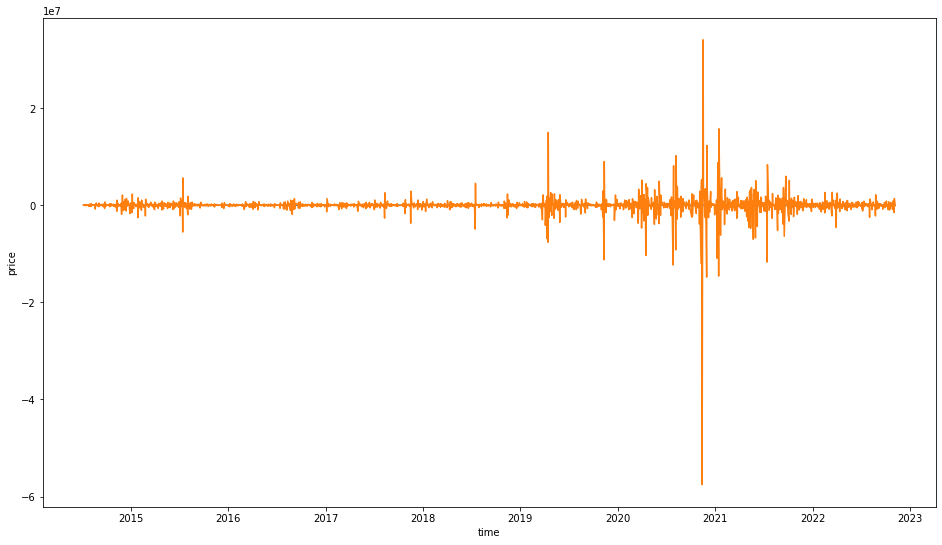

In [116]:
# 타겟변수 항공사 주가: aviation
plt.figure(figsize=(16,9))
plt.plot(aviation_sta)
plt.xlabel('time')
plt.ylabel('price')

In [117]:
# 네 개의 데이터 한 번에 그려보기

#fig, axes = plt.subplots(2, 2)
#fig.set_size_inches(16, 9)


## 데이터셋 필요한 형태로 만들기에서 정의한 dfs, names 리스트 사용
#for i in range( 2 ):
 #   ax = axes[i//2, i%2]
  #  sns.lineplot(y = dfs[i+1]['Close'], x = dfs[i+1].index, ax = ax)
   # ax.set_title('%s' % names[i+1])
   # ax.set_xlabel('time')
   # ax.set_ylabel('price')
#plt.tight_layout()
#plt.show()

In [118]:
# 변수간 상관관계 확인
## table
df_close.corr()

,AVIATION,Volume,OIL PRICE,SP500,USD,DJI
AVIATION,1.000000,0.333016,0.056960,0.081400,-0.158322,0.087616
Volume,0.333016,1.000000,-0.004288,0.023367,-0.019763,0.033670
OIL PRICE,0.056960,-0.004288,1.000000,0.067863,-0.054760,0.070340
SP500,0.081400,0.023367,0.067863,1.000000,0.021740,0.952731
USD,-0.158322,-0.019763,-0.054760,0.021740,1.000000,0.005843
DJI,0.087616,0.033670,0.070340,0.952731,0.005843,1.000000


<Figure size 1080x1080 with 0 Axes>

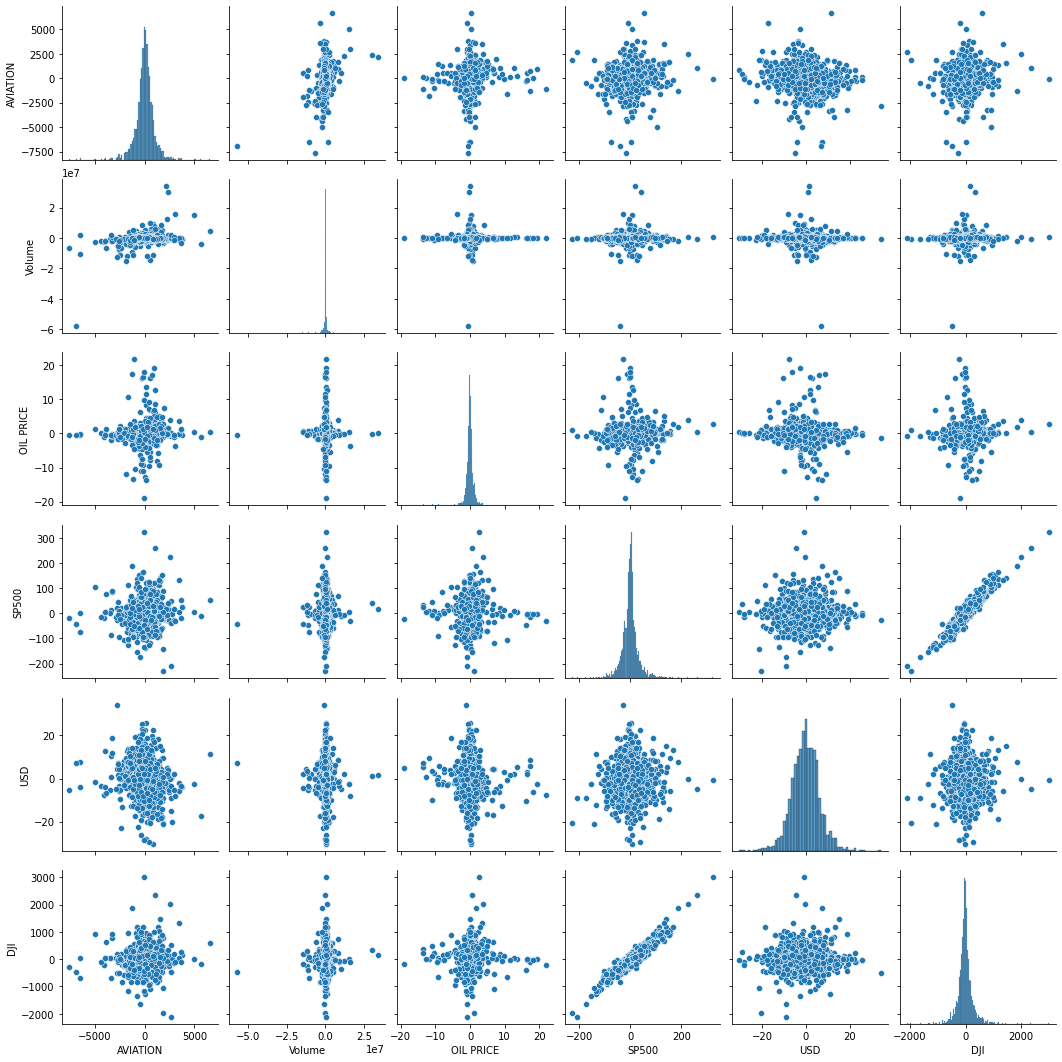

In [119]:
## 시각화
plt.figure(figsize=(15,15))
sns.pairplot(df_close)

선형 상관관계 찾을 수 없음

-> 선형 회귀분석 불가

-> LSTM 사용

# 4.데이터 전처리 (s_df_close)

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [120]:
from sklearn.preprocessing import MinMaxScaler

In [121]:
df_close.head()

,AVIATION,Volume,OIL PRICE,SP500,USD,DJI
Date,,,,,,
2014-07-08,336.14,38662.06,0.13,-9.119995,-0.200012,-78.990234
2014-07-09,34.02,-10834.99,0.55,8.149902,-0.200012,70.539062
2014-07-10,259.39,-71066.75,0.40,-2.889892,-1.200012,-28.740234
2014-07-11,-278.25,64442.99,-0.66,-9.530030,-6.299988,-111.609375
2014-07-14,7.19,-41698.70,0.59,3.819947,0.299988,-5.259766


In [122]:
scaler = MinMaxScaler()

# 데이터셋 필요한 형태로 만들기에서 정의한 리스트 names 사용
scale_cols = df_close.columns
scaled = scaler.fit_transform(df_close[scale_cols])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 유지했습니다.

*916개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [123]:
# Scaled DataFrame - 'CLOSE' column only
s_df_close = pd.DataFrame(scaled, columns = df_close.columns, 
                          index = df_close.index)   # 인덱스 여기서 추가

In [124]:
s_df_close

,AVIATION,Volume,OIL PRICE,SP500,USD,DJI
Date,,,,,,
2014-07-08,0.558749,0.628621,0.468834,0.398473,0.466553,0.398035
2014-07-09,0.537548,0.628081,0.479100,0.429575,0.466553,0.427297
2014-07-10,0.553363,0.627423,0.475434,0.409693,0.451104,0.407868
2014-07-11,0.515634,0.628903,0.449523,0.397734,0.372316,0.391652
2014-07-14,0.535665,0.627744,0.480078,0.421777,0.474277,0.412463
...,...,...,...,...,...,...
2022-10-28,0.594354,0.619048,0.499144,0.467268,0.454194,0.438708
2022-10-31,0.497721,0.637926,0.420680,0.443496,0.422987,0.429099
2022-11-01,0.536353,0.625929,0.425813,0.588525,0.594315,0.512403


# 5.데이터셋 train / test 분할

In [125]:
from sklearn.model_selection import train_test_split

In [126]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

x_train, x_test, y_train, y_test = train_test_split(s_df_close.drop('AVIATION', 1), # '여타 특성값들(독립변수들)'
                                                    s_df_close['AVIATION'],   # '예측하고 싶은 타겟(종속변수)'
                                                    test_size=0.2, 
                                                    random_state=0, shuffle=False)

In [127]:
# train dataset 학습용 데이터
x_train.shape, y_train.shape

((1587, 5), (1587,))

In [128]:
# test dataset 검증용 데이터
x_test.shape, y_test.shape

((397, 5), (397,))

In [129]:
x_train

,Volume,OIL PRICE,SP500,USD,DJI
Date,,,,,
2014-07-08,0.628621,0.468834,0.398473,0.466553,0.398035
2014-07-09,0.628081,0.479100,0.429575,0.466553,0.427297
2014-07-10,0.627423,0.475434,0.409693,0.451104,0.407868
2014-07-11,0.628903,0.449523,0.397734,0.372316,0.391652
2014-07-14,0.627744,0.480078,0.421777,0.474277,0.412463
...,...,...,...,...,...
2021-03-03,0.634993,0.440724,0.507195,0.389772,0.481192
2021-03-04,0.629852,0.428502,0.282583,0.410165,0.301526
2021-03-05,0.615217,0.475189,0.451978,0.560172,0.353584


# 6.TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [130]:
import tensorflow as tf

In [131]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

- WINDOW_SIZE = 20 : 과거 20일을 기반으로 그 다음 날의 데이터를 예측

In [132]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [133]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [134]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


# 7.모델

In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 최적화: filters = 16 모델

In [136]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters = 16, kernel_size = 5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [137]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [138]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [139]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     49/Unknown - 10s 7ms/step - loss: 0.0442 - mse: 0.0884
Epoch 1: val_loss improved from inf to 0.00257, saving model to tmp/ckeckpointer.ckpt
49/49 [==============================] - 11s 27ms/step - loss: 0.0442 - mse: 0.0884 - val_loss: 0.0026 - val_mse: 0.0051
Epoch 2/50
47/49 [===========================>..] - ETA: 0s - loss: 0.0024 - mse: 0.0048
Epoch 2: val_loss improved from 0.00257 to 0.00193, saving model to tmp/ckeckpointer.ckpt
49/49 [==============================] - 0s 8ms/step - loss: 0.0024 - mse: 0.0049 - val_loss: 0.0019 - val_mse: 0.0039
Epoch 3/50
41/49 [========================>.....] - ETA: 0s - loss: 0.0023 - mse: 0.0046
Epoch 3: val_loss improved from 0.00193 to 0.00192, saving model to tmp/ckeckpointer.ckpt
49/49 [==============================] - 0s 8ms/step - loss: 0.0023 - mse: 0.0047 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 4/50
46/49 [===========================>..] - ETA: 0s - loss: 0.0024 - mse: 0.0047
Epoch 4: val_loss did not improve fro

저장한 ModelCheckpoint 를 로드합니다.

In [140]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [141]:
# pred 변수에 예측값 저장
pred = model.predict(test_data)

12/12 [==============================] - 0s 6ms/step


In [142]:
pred.shape

(377, 1)

# 8.예측 데이터 시각화

## Re-Scaling & Date Indexing 
: 단위 되돌리고 날짜 인덱스 다시 추가

In [150]:
names

['AVIATION', 'Volume', 'OIL PRICE', 'SP500', 'USD', 'DJI']

### 검증용 데이터 rescaling
y_test >> y_test_rescale

In [151]:
y_test

Date
2021-03-10    0.509791
2021-03-11    0.500893
2021-03-12    0.521679
2021-03-15    0.455068
2021-03-16    0.498928
                ...   
2022-10-28    0.594354
2022-10-31    0.497721
2022-11-01    0.536353
2022-11-02    0.551196
2022-11-03    0.460457
Name: AVIATION, Length: 397, dtype: float64

In [152]:
y_test_df = pd.DataFrame(y_test)

for i in range(len(df_close.columns)):
  if i > 0:
    y_test_df[df_close.columns[i]] = 0
y_test_df

,AVIATION,Volume,OIL PRICE,SP500,USD,DJI
Date,,,,,,
2021-03-10,0.509791,0,0,0,0,0
2021-03-11,0.500893,0,0,0,0,0
2021-03-12,0.521679,0,0,0,0,0
2021-03-15,0.455068,0,0,0,0,0
2021-03-16,0.498928,0,0,0,0,0
...,...,...,...,...,...,...
2022-10-28,0.594354,0,0,0,0,0
2022-10-31,0.497721,0,0,0,0,0
2022-11-01,0.536353,0,0,0,0,0


In [153]:
names=df_close.columns

In [154]:
y_test_rescale = scaler.inverse_transform(y_test_df)
y_test_rescale = pd.DataFrame(y_test_rescale)

In [155]:
y_test_rescale

,0,1,2,3,4,5
0,-361.5,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
1,-488.3,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
2,-192.1,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
3,-1141.3,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
4,-516.3,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
...,...,...,...,...,...,...
392,843.5,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
393,-533.5,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
394,17.0,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
395,228.5,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468


### 예측값 데이터 rescaling
pred >> pred_rescale

In [156]:
pred_df = pd.DataFrame(pred)
for i in range(len(names)):
  if i > 0:
    pred_df[names[i]] = 0

In [157]:
pred_df

,0,Volume,OIL PRICE,SP500,USD,DJI
0,0.534506,0,0,0,0,0
1,0.534339,0,0,0,0,0
2,0.534325,0,0,0,0,0
3,0.533529,0,0,0,0,0
4,0.533994,0,0,0,0,0
...,...,...,...,...,...,...
372,0.531486,0,0,0,0,0
373,0.534296,0,0,0,0,0
374,0.531386,0,0,0,0,0
375,0.531879,0,0,0,0,0


In [158]:
pred_rescale = scaler.inverse_transform(pred_df)
pred_rescale = pd.DataFrame(pred_rescale)

In [159]:
pred_rescale

,0,1,2,3,4,5
0,-9.329595,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
1,-11.707778,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
2,-11.904828,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
3,-23.248763,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
4,-16.622125,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
...,...,...,...,...,...,...
372,-52.361128,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
373,-12.317612,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
374,-53.782942,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468
375,-46.752012,-57508005.4,-19.05,-230.380127,-30.400025,-2112.980468




---


아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

### 검증용 데이터 + DateTime Index
y_test_rescale >> y_test_graph

In [160]:
# y_test_graph: y_test_rescale[21:]의 인덱스에 Date time 추가

y_test_graph = y_test_rescale[0][21:]
y_test_graph = pd.DataFrame(y_test_graph)
y_test_graph.set_index(y_test_df[21:].index, inplace=True)
y_test_graph

,0
Date,
2021-04-09,136.5
2021-04-12,-262.0
2021-04-13,91.7
2021-04-14,-1.3
2021-04-15,3.7
...,...
2022-10-28,843.5
2022-10-31,-533.5
2022-11-01,17.0


### 예측값 데이터 + DateTime Index
pred_rescale >> pred_graph

In [161]:
# pred_graph: pred_rescale[:-1]의 인덱스에 Date time 추가

pred_graph = pred_rescale[0][:-1]
pred_graph = pd.DataFrame(pred_graph)
pred_graph.set_index(y_test_df[21:].index, inplace=True)
pred_graph

,0
Date,
2021-04-09,-9.329595
2021-04-12,-11.707778
2021-04-13,-11.904828
2021-04-14,-23.248763
2021-04-15,-16.622125
...,...
2022-10-28,-31.828910
2022-10-31,-52.361128
2022-11-01,-12.317612


## 시각화

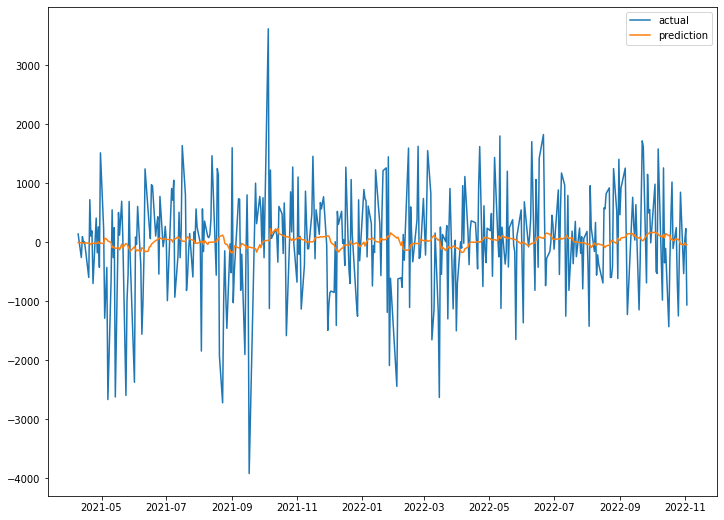

In [162]:
# 시각화

plt.figure(figsize=(12, 9))
plt.plot(y_test_graph, label='actual')
plt.plot(pred_graph, label='prediction')
plt.legend()
plt.show()

In [163]:
# 예측한 다음날(2022-10-28) 값
pred_graph[0][-1:]

Date
2022-11-03   -46.752012
Name: 0, dtype: float64

In [164]:
if pred_graph.iat[-1, 0] < 0:
  print('"예측 결과, %s 다음날의 가격은 %.2f(원) 상승합니다. 매수를 추천드립니다"' % ( str( pred_graph.index[-1] ), -pred_graph.iat[-1, 0] ))
elif pred_graph.iat[-1, 0] == 0:
  print('"예측 결과, %s 다음날의 가격은 변동 없습니다."' % ( str( pred_graph.index[-1] )))
else:
  print('"예측 결과, %s 다음날의 가격은 %.2f(원) 하락합니다. 매도를 추천드립니다"' % ( str( pred_graph.index[-1] ), -pred_graph.iat[-1, 0] ))

"예측 결과, 2022-11-03 00:00:00 다음날의 가격은 46.75(원) 상승합니다. 매수를 추천드립니다"
